# MLP classifier from scratch

## To do:
    1) figure out how to complete softmax derivative 
    2) try to add relu activation function for hidden layers
    3) compare the results to scikit-learn, be aware that scikit-learn should perform better since the 
    MLPClassifier has many more parameters than the classifier from scratch does. 
    4) clean up the code

## Notes

- Initially, my NN contained only one output neuron. By looking at the output intercepts from scikit-learn's MLP, I saw that they had 3 output neurons (each neuron serving as a probabilty of the output belonging to classes 1-3). Adopting this layout [178, 4, 4, 3] made the backpropogation step less complicated. The only odd step was having to reshape the target data loaded directly from scikit-learn which was done in the 4th cell.  
- After doing a quick comparison with the scikit-learn MLP classifier, it's obvious that their classifier has the ability to converge much faster than this one. Also, their implementation can achieve 100% accuracy where I've only seen about 95% accuracy at best here.
- learning curves look funny

In [1]:
%matplotlib inline

import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import sklearn


class my_MLPClassifier(object):
    """
    Basic MultiLayer Perceptron (MLP) neural network.
    Args:
    hidden layer: []
    max_iterations: []
    """
    def __init__(self, hidden, max_iter, 
                 learning_rate, decay_rate, 
                 activation='sigmoid', loss='mse'):
        """
        :param hidden: number of hidden neurons
        :param iterations: how many epochs
        :param learning_rate: initial learning rate
        """
        # initialize input parameters
        self.iterations = max_iter
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.n_hid1, self.n_hid2 = hidden[0], hidden[1]
        self.activation_method = activation
        self.loss_method = loss
    
    def fit(self, x, y):      
        """
        input: [178, 13] = [example, wine features]
        output: [178, 3] = [example, class probabilities] 
        """
        # Initialize the weights and bias according to the input/target data
        np.random.seed(50)
        dim_in, dim_out = x.shape[1], 3
        self.w1 = np.random.randn(dim_in, self.n_hid1) # [13,4] -- 52 weights 
        self.w2 = np.random.randn(self.n_hid1, self.n_hid2) # [4,4] -- 16 weights
        self.w3 = np.random.randn(self.n_hid2, dim_out) # [4,3] -- 12 weights
        self.b1 = np.random.randn(1,self.n_hid1) # [1,4] -- 4 biases
        self.b2 = np.random.randn(1,self.n_hid2) # [1,4] -- 4 biases
        self.b3 = np.random.randn(1,dim_out)  # [1,3] -- 3 bias
        loss_hist = [] # track loss for printing
        
        for i in range(self.iterations):
            
            # forward
            (h1,h2,y_) = self.forward(x)
            cost = self.log_loss(y_,y) 
            loss_hist.append(cost)
            
            # backprop
            delta3 = self.grad_loss(y_, y) * self.grad_softmax(y_) 
            gradw3 = np.dot(np.transpose(h2),delta3)
            gradb3 = np.sum(delta3,axis = 0)
            
            delta2 = np.dot(delta3,np.transpose(self.w3)) * self.grad_activation(h2)
            gradw2 = np.dot(np.transpose(h1),delta2)
            gradb2 = np.sum(delta2,axis = 0)
            
            delta = np.dot(delta2,np.transpose(self.w2)) * self.grad_activation(h1)
            gradw = np.dot(np.transpose(x),delta)
            gradb = np.sum(delta,axis = 0)
            
            # update parameters
            learning_rate = self.learning_rate * (self.decay_rate**i)
            self.w3 += -learning_rate*gradw3
            self.b3 += -learning_rate*gradb3
            self.w2 += -learning_rate*gradw2
            self.b2 += -learning_rate*gradb2
            self.w1 += -learning_rate*gradw
            self.b1 += -learning_rate*gradb
        self.weights = (self.w3, self.w2, self.w1)
        self.bias = (self.b3, self.b2, self.b1)
        
        # print the loss
        print('activation function: %s, loss function: %s = %s, iterations: %s, learning rate: %s'
              %(self.activation_method,self.loss_method,round(cost,3),self.iterations,self.learning_rate))
        
        # plot the training curve
        plt.title('training curve')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.plot(np.arange(0,self.iterations),loss_hist)
        
    def activation(self,x):
        if self.activation_method == 'sigmoid':
            return 1./(1+np.exp(-x))
        elif self.activation_method == 'tanh':
            return np.tanh(x)
        else:
            print('%s not a valid activation function' %(self.activation_method))


    def log_loss(self,y_,y):
        if self.loss_method == 'logloss':
            return -1/y_.shape[0] * np.sum(y * np.log(y_))
        elif self.loss_method == 'mse':
            return 0.5/y_.shape[0] * np.sum(np.power(y_-y,2))

    def grad_loss(self,y_,y):
        return  y_ - y

    def grad_activation(self,x):
        if self.activation_method == 'sigmoid': 
            return self.activation(x) * (1-self.activation(x))
        elif self.activation_method == 'tanh':
            return 1-self.activation(x)**2

    def softmax(self,x):
        return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
    
    def grad_softmax(self,x): # this doesn't take into account when the indices in softmax aren't equal, might be incomplete
        return self.softmax(x) * (1-self.activation(x))
        
    def forward(self,x):
        h1 = np.dot(x,self.w1)+self.b1
        h1 = self.activation(h1)
        h2 = np.dot(h1,self.w2)+self.b2
        h2 = self.activation(h2)
        y_ = np.dot(h2,self.w3)+self.b3
        y_ = self.softmax(y_) # use softmax strictly for output, commonly used for multi-classification problems
        return(h1,h2,y_)
    
    def predict(self, x):
        (h1, h2, y) = self.forward(x)
        y_ = np.zeros(y.shape[0],int) # array to reshape predictions to (178,)
        # this for loop goes through the predictions shaped (178,3) and places it into the same form as original target
        # data size (178,) for comparison ~~ probably an easier way to do this
        for i in range(len(y)):
            for j in range(len(y[i])):
                y[i,j] = round(y[i,j],0)
            y_[i] = np.argmax(y[i])
        
        return y_




In [2]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler

# load the data
data=load_wine()
x,Y = data.data, data.target

#scale the data
scaler = StandardScaler()  
scaler.fit(x)  
x0 = scaler.transform(x)

# here i reshape the target list (178,) to (178,3), might be a better way to do this
y = np.zeros((178,3))
for i in range(len(Y)):
    if Y[i] == 0 :
        y[i,0] = 1
        y[i,1] = 0
        y[i,2] = 0
    elif Y[i] == 1:
        y[i,0] = 0
        y[i,1] = 1
        y[i,2] = 0
    else:
        y[i,0] = 0
        y[i,1] = 0
        y[i,2] = 1
print(y)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0.

activation function: tanh, loss function: mse = 0.054, iterations: 100, learning rate: 0.01
predicted values
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0
 0 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
target values
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
accuracy after 100 iterations is: 95.5 percent


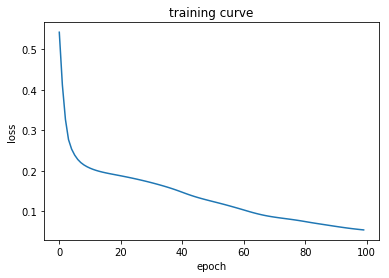

In [3]:
max_iter=100
my_mlp = my_MLPClassifier(hidden=[4,4],max_iter=max_iter,learning_rate=0.01,decay_rate=0.99,
                          activation='tanh',loss='mse')
my_mlp.fit(x0,y)
y_ = my_mlp.predict(x0) # predictions in shape (173,3)
print('predicted values')
print(y_) 
print('target values')
print(Y) 
count = 0
for i in range(len(y_)):
    if y_[i] == Y[i]:
        count += 1
print('accuracy after %s iterations is: %s percent' %(max_iter,100*round(count/len(y_),3)))

activation function: tanh, loss function: logloss = 0.233, iterations: 100, learning rate: 0.01
predicted values
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0
 0 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
target values
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
accuracy after 100 iterations is: 95.5 percent


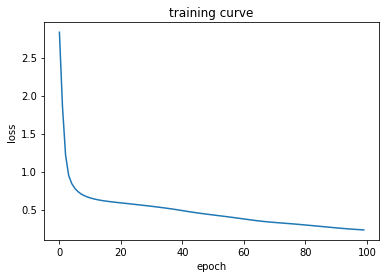

In [4]:
max_iter=100
my_mlp = my_MLPClassifier(hidden=[4,4],max_iter=max_iter,learning_rate=0.01,decay_rate=0.99,
                          activation='tanh',loss='logloss')
my_mlp.fit(x0,y)
y_ = my_mlp.predict(x0) # predictions in shape (173,3)
print('predicted values')
print(y_) 
print('target values')
print(Y) 
count = 0
for i in range(len(y_)):
    if y_[i] == Y[i]:
        count += 1
print('accuracy after %s iterations is: %s percent' %(max_iter,100*round(count/len(y_),3)))

activation function: sigmoid, loss function: logloss = 0.14, iterations: 1000, learning rate: 0.1
predicted values
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 0 1 0
 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
target values
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
accuracy after 1000 iterations is: 93.30000000000001 percent


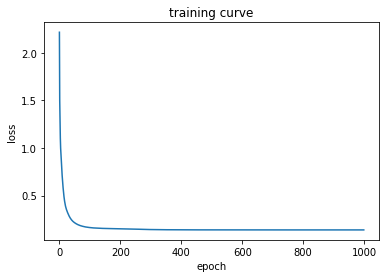

In [5]:
max_iter=1000
my_mlp = my_MLPClassifier(hidden=[4,4],max_iter=max_iter,learning_rate=0.1,decay_rate=0.99,
                          activation='sigmoid',loss='logloss')
my_mlp.fit(x0,y)
y_ = my_mlp.predict(x0) # predictions in shape (173,3)
print('predicted values')
print(y_) 
print('target values')
print(Y) 
count = 0
for i in range(len(y_)):
    if y_[i] == Y[i]:
        count += 1
print('accuracy after %s iterations is: %s percent' %(max_iter,100*round(count/len(y_),3)))

activation function: sigmoid, loss function: mse = 0.037, iterations: 1000, learning rate: 0.1
predicted values
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 0 1 0
 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
target values
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
accuracy after 1000 iterations is: 93.30000000000001 percent


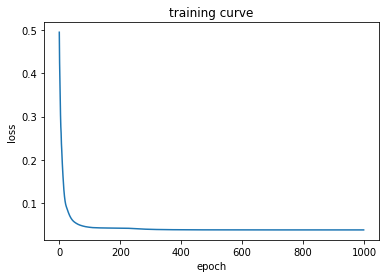

In [6]:
max_iter=1000
my_mlp = my_MLPClassifier(hidden=[4,4],max_iter=max_iter,learning_rate=0.1,decay_rate=0.99,
                          activation='sigmoid',loss='mse')
my_mlp.fit(x0,y)
y_ = my_mlp.predict(x0) # predictions in shape (173,3)
print('predicted values')
print(y_) 
print('target values')
print(Y) 
count = 0
for i in range(len(y_)):
    if y_[i] == Y[i]:
        count += 1
print('accuracy after %s iterations is: %s percent' %(max_iter,100*round(count/len(y_),3)))